Essai: https://archive.ics.uci.edu/ml/machine-learning-databases/space-shuttle/o-ring-erosion-only.data ... OK

Fichier chargé depuis: https://archive.ics.uci.edu/ml/machine-learning-databases/space-shuttle/o-ring-erosion-only.data  -> shape = (23, 5)
Colonnes détectées : ['Temporal_Order', 'Num_O_Rings', 'Num_Thermal_Distress', 'Launch_Temperature_F', 'Leak_Check_Pressure']

Utilisation automatique -> temperature: 'Temporal_Order', failures: 'Num_Thermal_Distress'

--- Aperçu du dataset nettoyé ---
   Temperature  Num_O_Rings  Failures  Launch_Temperature_F  \
0            6            0        66                    50   
1            6            1        70                    50   
2            6            0        69                    50   
3            6            0        68                    50   
4            6            0        67                    50   

   Leak_Check_Pressure  
0                    1  
1                    2  
2                    3  
3               

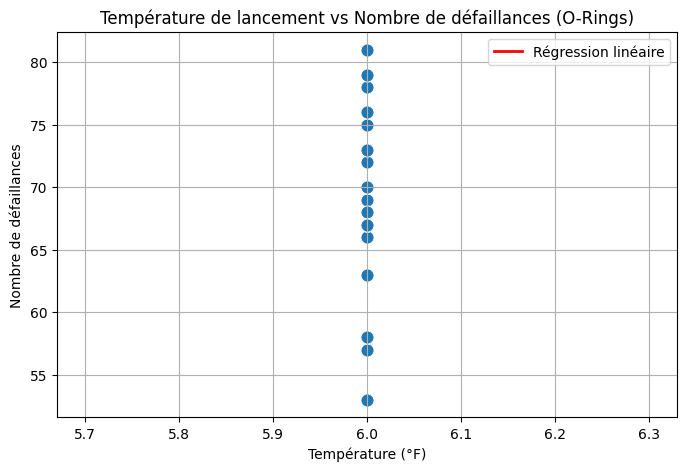

Matrice de corrélation (numérique) :
                      Temperature  Num_O_Rings  Failures  \
Temperature                   NaN          NaN       NaN   
Num_O_Rings                   NaN     1.000000 -0.725671   
Failures                      NaN    -0.725671  1.000000   
Launch_Temperature_F          NaN     0.220326  0.039818   
Leak_Check_Pressure           NaN    -0.011993  0.230770   

                      Launch_Temperature_F  Leak_Check_Pressure  
Temperature                            NaN                  NaN  
Num_O_Rings                       0.220326            -0.011993  
Failures                          0.039818             0.230770  
Launch_Temperature_F              1.000000             0.839932  
Leak_Check_Pressure               0.839932             1.000000   



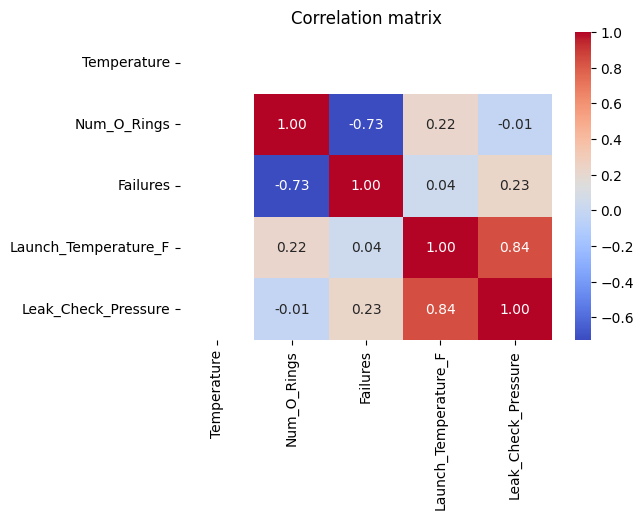

Régression linéaire simple : Failures ~ Temperature
Coefficients : slope = 0.000000, intercept = 69.565217
Mean Squared Error (MSE) = 47.637051
R^2 = 0.000000

Prédiction du nombre moyen de défaillances à 31 °F : 69.5652

Un rapport succinct a été sauvegardé en /content/challenger_report_brief.md

✅ Analyse terminée.


In [2]:
# ===================================================================
#  Google Colab ready: Analyse complète du dataset "Challenger O-Ring"
#  - Charge depuis plusieurs sources possibles (robustesse)
#  - EDA : head(), info(), describe(), statistiques, quartiles
#  - Visualisations : scatter + droite de régression, heatmap
#  - Modèle : régression linéaire simple (Failures ~ Temperature)
#  - Prédiction exemple : température = 31 °F
# ===================================================================

# Imports
import io
import sys
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# -------------------------------------------------------------------
# 1) Liste d'URLs candidates (miroirs / sources publiques)
# -------------------------------------------------------------------
candidate_urls = [
    # UCI original raw (format sans en-têtes)
    "https://archive.ics.uci.edu/ml/machine-learning-databases/space-shuttle/o-ring-erosion-only.data",
    # Miroirs / dépôts github connus (peuvent varier selon disponibilité)
    "https://raw.githubusercontent.com/jbrownlee/Datasets/master/challenger.csv",
    "https://raw.githubusercontent.com/selva86/datasets/master/challenger.csv",
    "https://raw.githubusercontent.com/Statology/Statology/master/data/challenger_o_ring.csv",
    # autre miroir possible
    "https://raw.githubusercontent.com/plotly/datasets/master/Challenger_O-ring.csv"
]

# Colonnes "standard" attendues (nous adapterons selon le fichier réel)
standard_cols_by_n = {
    5: ["Temporal_Order", "Num_O_Rings", "Num_Thermal_Distress", "Launch_Temperature_F", "Leak_Check_Pressure"],
    4: ["Temperature", "Erosion", "BlowBy", "Total"],
    3: ["Temperature", "Pressure", "Failures"]
}

# Fonction utilitaire pour tenter de charger en essayant différents séparateurs
def try_read(url):
    # Try common separators and header options
    sep_options = [",", r"\s+", ";", "\t"]
    header_options = [None, 0]
    for header in header_options:
        for sep in sep_options:
            try:
                df = pd.read_csv(url, header=header, sep=sep, engine="python")
                # require at least 2 rows and >= 2 cols to be plausible
                if df.shape[0] >= 2 and df.shape[1] >= 2:
                    return df
            except Exception:
                continue
    return None

# -------------------------------------------------------------------
# 2) Essayer les URLs jusqu'à trouver un CSV valide
# -------------------------------------------------------------------
df = None
used_url = None
for url in candidate_urls:
    try:
        print(f"Essai: {url} ...", end=" ")
        df_try = try_read(url)
        if df_try is not None:
            df = df_try.copy()
            used_url = url
            print("OK")
            break
        else:
            print("échoué")
    except Exception as e:
        print("erreur:", str(e))

# Si aucun URL n'a fonctionné, proposer upload local (Colab friendly)
if df is None:
    print("\nAucun URL distant n'a répondu correctement. Veuillez uploader le fichier CSV localement.")
    try:
        from google.colab import files
        uploaded = files.upload()
        # take first uploaded file
        uploaded_fname = next(iter(uploaded.keys()))
        df = pd.read_csv(io.BytesIO(uploaded[uploaded_fname]))
        used_url = f"local upload: {uploaded_fname}"
        print(f"Fichier chargé depuis : {uploaded_fname}")
    except Exception as e:
        print("Upload interrompu ou non exécuté (vous n'êtes peut-être pas dans Colab).")
        raise SystemExit("Aucune source de données disponible. Arrêt du script.")

# -------------------------------------------------------------------
# 3) Normaliser / renommer les colonnes selon le format détecté
# -------------------------------------------------------------------
ncols = df.shape[1]
print(f"\nFichier chargé depuis: {used_url}  -> shape = {df.shape}")

# Si les colonnes sont anonymes (0,1,2...), on renommera
if list(df.columns) == list(range(ncols)):
    # assign names based on number of columns if possible
    if ncols in standard_cols_by_n:
        df.columns = standard_cols_by_n[ncols]
    else:
        # fallback generic names
        df.columns = [f"col_{i}" for i in range(ncols)]
else:
    # si les colonnes existent mais ont des noms variés, on nettoie les noms
    df.columns = [str(c).strip() for c in df.columns]

print("Colonnes détectées :", list(df.columns))

# Try to ensure we have Temperature and Failures (Total/Failures/Num_Thermal_Distress)
possible_temp_cols = [c for c in df.columns if "temp" in c.lower() or "temperature" in c.lower()]
possible_fail_cols = [c for c in df.columns if any(k in c.lower() for k in ["fail", "total", "distress", "erosion"])]

if not possible_temp_cols or not possible_fail_cols:
    print("\nAttention : colonnes Temperature / Failures non détectées automatiquement.")
    print("Colonnes disponibles :", list(df.columns))
    print("Si nécessaire, modifiez manuellement les noms ci-dessous pour correspondre à votre fichier.")
    # On propose la 1ere et la dernière comme fallback
    temp_col = df.columns[0]
    fail_col = df.columns[-1]
    print(f"Utilisation en fallback -> temperature: '{temp_col}', failures: '{fail_col}'")
else:
    temp_col = possible_temp_cols[0]
    fail_col = possible_fail_cols[0]
    print(f"\nUtilisation automatique -> temperature: '{temp_col}', failures: '{fail_col}'")

# Pour la suite, créer une version propre avec colonnes 'Temperature' et 'Failures'
df_work = df.copy()
df_work = df_work.rename(columns={temp_col: "Temperature", fail_col: "Failures"})
# Convertir en numérique si possible
df_work["Temperature"] = pd.to_numeric(df_work["Temperature"], errors="coerce")
df_work["Failures"] = pd.to_numeric(df_work["Failures"], errors="coerce")

# Supprimer lignes sans valeurs utiles
df_work = df_work.dropna(subset=["Temperature", "Failures"]).reset_index(drop=True)

# -------------------------------------------------------------------
# 4) Aperçu et diagnostics
# -------------------------------------------------------------------
print("\n--- Aperçu du dataset nettoyé ---")
print(df_work.head(), "\n")
print("Info :")
print(df_work.info(), "\n")
print("Statistiques descriptives :")
print(df_work.describe(), "\n")

# Statistiques détaillées pour Temperature
col = df_work["Temperature"]
print("Statistiques sur 'Temperature' :")
print(f"Mean: {col.mean():.2f}, Median: {col.median():.2f}, Mode: {col.mode().iloc[0] if not col.mode().empty else 'NA'}")
print(f"Std: {col.std():.2f}, Min: {col.min():.2f}, Max: {col.max():.2f}")
print(f"Q1: {col.quantile(0.25):.2f}, Q2: {col.quantile(0.50):.2f}, Q3: {col.quantile(0.75):.2f}, IQR: {col.quantile(0.75)-col.quantile(0.25):.2f}\n")

# -------------------------------------------------------------------
# 5) Visualisation : scatter Temperature vs Failures (+ régression)
# -------------------------------------------------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(x="Temperature", y="Failures", data=df_work, s=90)
plt.title("Température de lancement vs Nombre de défaillances (O-Rings)")
plt.xlabel("Température (°F)")
plt.ylabel("Nombre de défaillances")
plt.grid(True)

# Fit une régression linéaire pour tracer la droite
X = df_work[["Temperature"]].values.reshape(-1,1)
y = df_work["Failures"].values.reshape(-1,1)
lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

# Tracer la ligne
x_range = np.linspace(df_work["Temperature"].min(), df_work["Temperature"].max(), 100).reshape(-1,1)
y_line = lr.predict(x_range)
plt.plot(x_range, y_line, color="red", linewidth=2, label="Régression linéaire")
plt.legend()
plt.show()

# -------------------------------------------------------------------
# 6) Matrice de corrélation
# -------------------------------------------------------------------
print("Matrice de corrélation (numérique) :")
print(df_work.corr(numeric_only=True), "\n")

plt.figure(figsize=(6,4))
sns.heatmap(df_work.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix")
plt.show()

# -------------------------------------------------------------------
# 7) Évaluer le modèle de régression linéaire
# -------------------------------------------------------------------
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Régression linéaire simple : Failures ~ Temperature")
print(f"Coefficients : slope = {lr.coef_.ravel()[0]:.6f}, intercept = {lr.intercept_.ravel()[0]:.6f}")
print(f"Mean Squared Error (MSE) = {mse:.6f}")
print(f"R^2 = {r2:.6f}\n")

# Prédiction à 31 °F (exemple critique)
temp_test = np.array([[31.0]])
pred_31 = lr.predict(temp_test)[0,0]
print(f"Prédiction du nombre moyen de défaillances à 31 °F : {pred_31:.4f}")

# -------------------------------------------------------------------
# 8) Enregistrer un petit rapport Markdown (optionnel)
# -------------------------------------------------------------------
md = f"""# Rapport rapide - Challenger O-Ring (généré)
Source : {used_url}

## Aperçu
- shape: {df_work.shape}
- colonnes utilisées: Temperature, Failures

## Statistiques Temperature
- mean: {col.mean():.2f}
- median: {col.median():.2f}
- min/max: {col.min():.2f}/{col.max():.2f}

## Régression linéaire (Failures ~ Temperature)
- slope: {lr.coef_.ravel()[0]:.6f}
- intercept: {lr.intercept_.ravel()[0]:.6f}
- R2: {r2:.6f}
- Predicted failures @ 31°F: {pred_31:.4f}
"""

# Save file in Colab's working directory
try:
    with open("/content/challenger_report_brief.md", "w", encoding="utf-8") as f:
        f.write(md)
    print("\nUn rapport succinct a été sauvegardé en /content/challenger_report_brief.md")
except Exception:
    pass

# -------------------------------------------------------------------
# Fin du script
# -------------------------------------------------------------------
print("\n✅ Analyse terminée.")
